MNIST Dataset을 사용하였음.

In [1]:
pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h2> 막코드

In [2]:
%matplotlib inline
import torch
import torchvision
from IPython import display
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

In [3]:
trans = transforms.Compose([
                            transforms.Resize((28,28)),
                            transforms.ToTensor()])
MNIST_train = torchvision.datasets.MNIST(
root="../data", train=True, transform=trans, download=True)
MNIST_test = torchvision.datasets.MNIST(
root="../data", train=False, transform=trans, download=True)

In [4]:
MNIST_train #60000개의 이미지파일

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [5]:
MNIST_test #10000개의 이미지파일

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [6]:
MNIST_train.classes[:], len(MNIST_train.classes)

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 10)

In [7]:
MNIST_train[0][0].shape #Fashion-MNIST랑 같은 타입.

torch.Size([1, 28, 28])

In [8]:
def get_labels(labels):
  """텍스트 라벨 반환"""
  text_labels = MNIST_train.classes#내장 attribute로, label 이름의 리스트를 반환한다.
  return [text_labels[int(i)]for i in labels]

In [9]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols*scale, num_rows*scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
      ax.imshow(img.numpy())
    else:
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  return axes

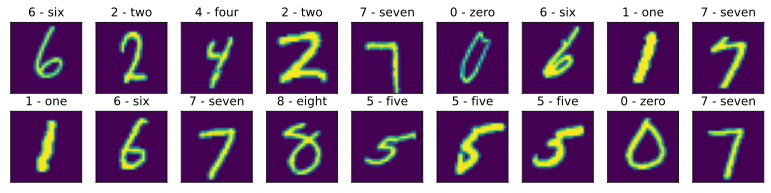

In [10]:
X, y = next(iter(data.DataLoader(MNIST_train, shuffle=True, batch_size=18)))
show_images(X.reshape(18,28,28), 2, 9, titles=get_labels(y));

In [11]:
torch.utils.data.get_worker_info()

In [12]:
def get_dataloader_workers(): 
  """Use 2 processes to read the data."""
  return 2#colab 환경이라 2로 설정하였음.


def load_data_MNIST(batch_size, resize=None): 
  """Download the MNIST dataset and then load it into memory."""
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  MNIST_train = torchvision.datasets.MNIST(
  root="../data", train=True, transform=trans, download=True)
  MNIST_test = torchvision.datasets.MNIST(
  root="../data", train=False, transform=trans, download=True)
  return (data.DataLoader(MNIST_train, batch_size, shuffle=True,
  num_workers=get_dataloader_workers()),
  data.DataLoader(MNIST_train, batch_size, shuffle=False,
  num_workers=get_dataloader_workers()))


In [13]:
batch_size = 256
train_iter, test_iter = load_data_MNIST(batch_size, resize=(28,28))

In [14]:
num_inputs = 784
num_outputs = 10 #class 개수가 10개이므로.
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)


In [15]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True)
  return X_exp / partition

def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

def cross_entropy(y_hat, y):
  return - torch.log(y_hat[range(len(y_hat)), y])

def accuracy(y_hat, y): 
  """Compute the number of correct predictions."""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.type(y.dtype) == y #y의 dtype으로 변환후, y와 비교 ([True, False, False])이런 식의 결과값 나옴.
  return float(cmp.type(y.dtype).sum())

In [16]:
def evaluate_accuracy(net, data_iter): 
  """Compute the accuracy for a model on a dataset."""
  if isinstance(net, torch.nn.Module):#Module에 'net'이라는 인스턴스 존재시.
    net.eval() # Set the model to evaluation mode
  metric = Accumulator(2) # No. of correct predictions, no. of predictions
  with torch.no_grad():
    for X, y in data_iter:
      metric.add(accuracy(net(X), y), y.numel())#.numel()은 텐서 크기 구하는 함수.
  return metric[0] / metric[1]


In [17]:
class Accumulator:
  """For accumulating sums over `n` variables."""
  def __init__(self, n):
    self.data = [0.0] * n
  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]
  def reset(self):
    self.data = [0.0] * len(self.data)
  def __getitem__(self, idx):
    return self.data[idx]


In [18]:
evaluate_accuracy(net, test_iter)


0.07655

In [19]:
def train_epoch_ch3(net, train_iter, loss, updater): 
  """The training loop defined in Chapter 3."""
  # Set the model to training mode
  if isinstance(net, torch.nn.Module):
    net.train()
  # Sum of training loss, sum of training accuracy, no. of examples
  metric = Accumulator(3)
  for X, y in train_iter:
    # Compute gradients and update parameters
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
      # Using PyTorch in-built optimizer & loss criterion
      updater.zero_grad()
      l.mean().backward()
      updater.step()
    else:
      # Using custom built optimizer & loss criterion
      l.sum().backward()
      updater(X.shape[0])
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
  # Return training loss and training accuracy
  return metric[0] / metric[2], metric[1] / metric[2]

In [20]:
class Animator: 
  """For plotting data in animation."""
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
    ylim=None, xscale='linear', yscale='linear',
    fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
    figsize=(3.5, 2.5)):
    # Incrementally plot multiple lines
    if legend is None:
      legend = []
    d2l.use_svg_display()
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    # Use a lambda function to capture arguments
    self.config_axes = lambda: d2l.set_axes(
      self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts

  def add(self, x, y):
    # Add multiple data points into the figure
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a, b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)


In [21]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
  """Train a model (defined in Chapter 3)."""
  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
          legend=['train loss', 'train acc', 'test acc'])
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
  train_loss, train_acc = train_metrics
  assert train_loss < 0.5, train_loss
  assert train_acc <= 1 and train_acc > 0.7, train_acc
  assert test_acc <= 1 and test_acc > 0.7, test_acc

In [22]:
lr = 0.1
def updater(batch_size):
  return d2l.sgd([W, b], lr, batch_size)

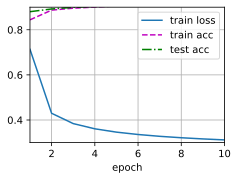

In [23]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

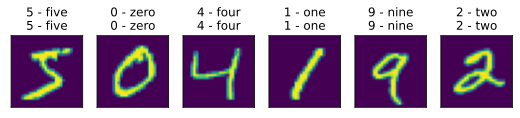

In [24]:
def predict_ch3(net, test_iter, n=6):
  """Predict labels (defined in Chapter 3)."""
  for X, y in test_iter:
    break
  trues = get_labels(y)
  preds = get_labels(net(X).argmax(axis=1))
  titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
  show_images(
  X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
predict_ch3(net, test_iter)


<h2> 모듈 사용

In [25]:
from torch import nn


In [26]:
batch_size = 256
train_iter, test_iter = load_data_MNIST(batch_size, resize=(28,28))

In [27]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

In [28]:
loss = nn.CrossEntropyLoss(reduction='none')

In [29]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

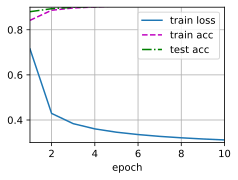

In [30]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

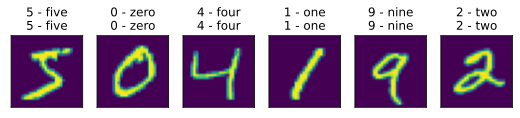

In [31]:
predict_ch3(net, test_iter)